# Семинар 1. Границы применимости моделей и зачем в ML-алгоритмах всякие "ненужные" параметры

Этот семинар не претендует на исчерпывающее системное изложение заявленной темы, однако на ряде примеров иллюстрирует вынесенный в заголовок вопрос и возможные подходы к его решению

# 1. Регрессия и экстраполяция коробки

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
np.random.seed(42)

:Нарисуем зашумленную прямую, пусть это будет наш train

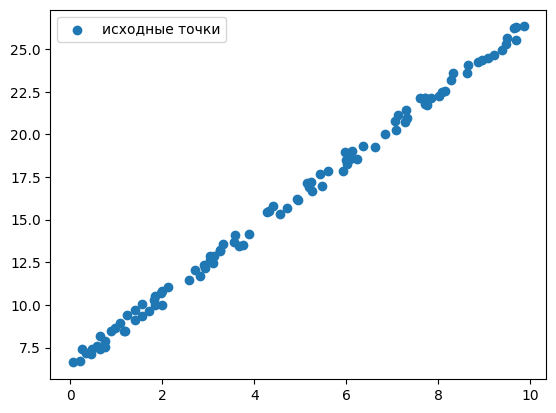

In [19]:
n = 100
slope = 2
bias = 6
mult = 10
oos_2_bias = 10

x = np.random.random(n)*mult
y = x * slope + bias + np.random.random(n)

sc = plt.scatter(x, y, label='исходные точки')
_ = plt.legend()

Сгенерим еще пару OOS для теста

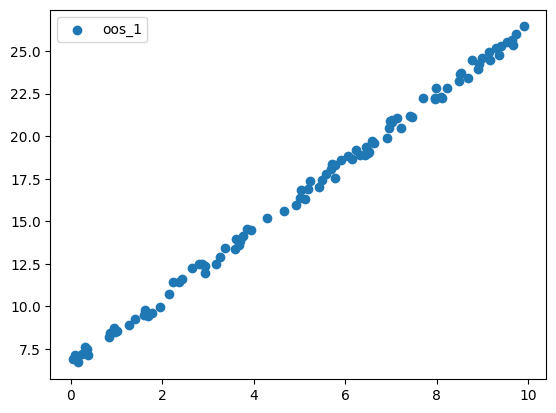

In [20]:
oos_x_1 = np.random.random(n)*mult
oos_y_1 = oos_x_1 * slope + bias + np.random.random(n)
_ = plt.scatter(oos_x_1, oos_y_1, label = 'oos_1')
_ = plt.legend()

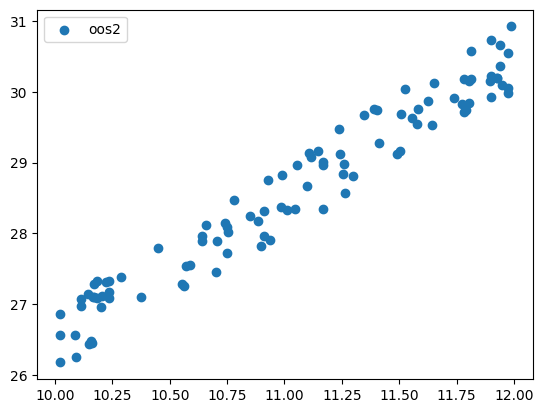

In [21]:
oos_x_2 = (np.random.random(n)*slope + oos_2_bias )
oos_y_2 = oos_x_2 * slope + bias + np.random.random(n)
_ = plt.scatter(oos_x_2, oos_y_2, label = 'oos2')
plt.legend()

А теперь все вместе

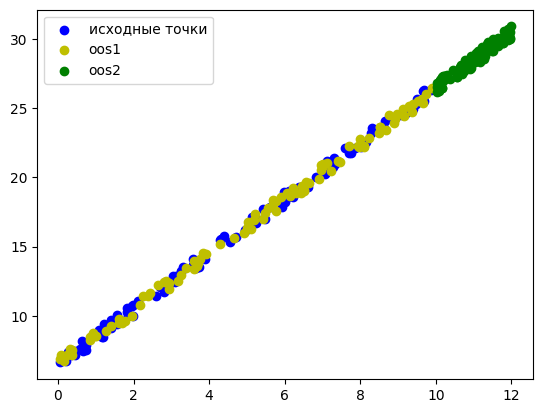

In [22]:
plt.scatter(x, y, c = 'b', label = 'исходные точки')
plt.scatter(oos_x_1, oos_y_1, c = 'y', label = 'oos1')
plt.scatter(oos_x_2, oos_y_2, c = 'g', label = 'oos2')
_ = plt.legend()

Проверим как линейная регрессия справится с обоими тестовыми множествами

0.9974842479666531
0.9438305194669983


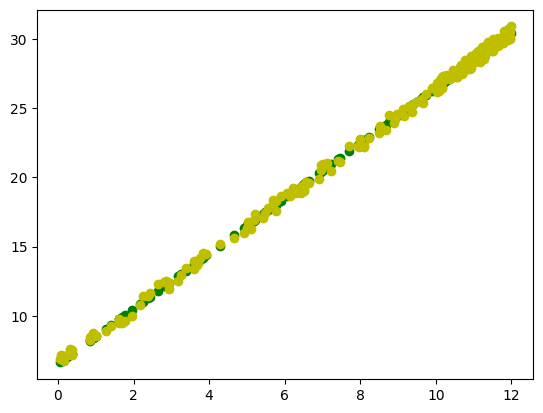

In [23]:
lr = LinearRegression()
lr.fit(x.reshape(-1,1), y)

print(lr.score(oos_x_1.reshape(-1,1), oos_y_1))
print(lr.score(oos_x_2.reshape(-1,1), oos_y_2))

_ = plt.scatter(oos_x_1, lr.predict(oos_x_1.reshape(-1,1)), c='g')
_ = plt.scatter(oos_x_2, lr.predict(oos_x_2.reshape(-1,1)), c='g')
_ = plt.scatter(oos_x_1, oos_y_1, c='y')
_ = plt.scatter(oos_x_2, oos_y_2, c='y')

Линейная регрессия справилась отлично! Теперь подключим LGBM



In [24]:
dt = XGBRegressor()
_ = dt.fit(x.reshape(-1,1),y, verbose = False)
print(dt.score(oos_x_1.reshape(-1,1), oos_y_1))
print(dt.score(oos_x_2.reshape(-1,1), oos_y_2))

0.9943678637859522
-3.2194567439466404


Ого! кто скажет что случилось?

Нарисуем?

0.9943678637859522
-3.2194567439466404


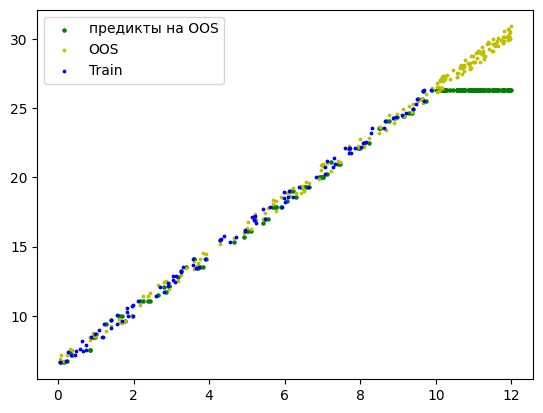

In [25]:
print(dt.score(oos_x_1.reshape(-1,1), oos_y_1))
print(dt.score(oos_x_2.reshape(-1,1), oos_y_2))
plt.scatter(oos_x_1, dt.predict(oos_x_1.reshape(-1,1)), c='g', label='предикты на OOS', s = 5)
plt.scatter(oos_x_2, dt.predict(oos_x_2.reshape(-1,1)), c='g', s = 5)
plt.scatter(oos_x_1, oos_y_1, c='y', label='OOS', s = 3)
plt.scatter(oos_x_2, oos_y_2, c='y', s = 3)

plt.scatter(x, y, c='b', label='Train', s = 3)
_ = plt.legend()

Кто может объяснить? Как починить?

In [26]:
dt2 = XGBRegressor(booster = 'gblinear')
_ = dt2.fit(x.reshape(-1,1),y, verbose = False)
print(dt2.score(oos_x_1.reshape(-1,1), oos_y_1))
print(dt2.score(oos_x_2.reshape(-1,1), oos_y_2))

0.9974847930100482
0.9438131808447259


Стало лучше! нарисуем

0.9974847930100482
0.9438131808447259


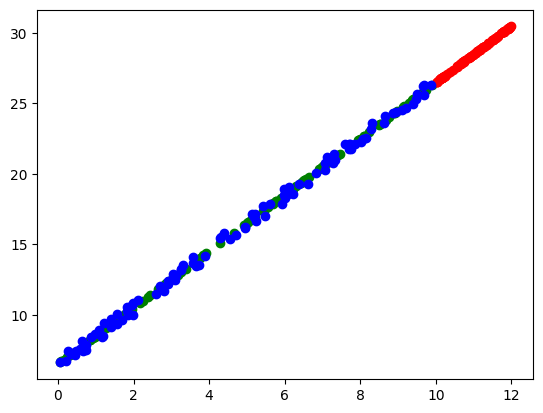

In [27]:
print(dt2.score(oos_x_1.reshape(-1,1), oos_y_1))
print(dt2.score(oos_x_2.reshape(-1,1), oos_y_2))
_ = plt.scatter(oos_x_1, dt2.predict(oos_x_1.reshape(-1,1)), c='g')
_ = plt.scatter(oos_x_2, dt2.predict(oos_x_2.reshape(-1,1)), c='r')
_ = plt.scatter(x, y, c='b')

А в LightGBM так просто и не починишь )

На подумать -- как именно работает градиентный бустинг над линейными моделями?

Про бизнес? Вы уверены что на инференсе не придет цена больше максимальной из трейна (точнее больше наибольшей средней в листах)?

# Новый раздел

# 2. Еще про границы применимости моделей -- с интерполяцией тоже не так гладко

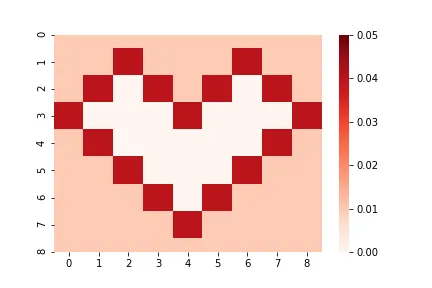

[сердечки в катбусте](https://github.com/catboost/catboost/blob/master/catboost/tutorials/uncertainty/uncertainty_regression.ipynb)

[и еще сердечки](https://towardsdatascience.com/tutorial-uncertainty-estimation-with-catboost-255805ff217e)

[Ын-буст NGBoost](https://stanfordmlgroup.github.io/projects/ngboost/)

In [53]:
# !pip install catboost -q

In [56]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
np.random.seed(42)

In [57]:
n_features = 10
n_samples = 20000
data = make_regression(n_samples = n_samples, n_features =n_features, random_state = 42)
df = pd.DataFrame(data[0], columns = [f'feature_{k}' for k in range(n_features)])
df['target'] = data[1]

In [58]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['target'], axis = 1), df['target'], test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
train_pool = Pool(x_train, y_train)
val_pool = Pool(x_val, y_val)
cbr = CatBoostRegressor(
                          loss_function='RMSE', posterior_sampling=True,
                          verbose=False, random_seed=42)
cbr.fit(train_pool, eval_set=val_pool, verbose = False)
print(mean_squared_error(y_test, cbr.predict(x_test)))

87.2493084202163


In [59]:
model = CatBoostRegressor(
                          loss_function='RMSEWithUncertainty', posterior_sampling=True,
                          verbose=False, random_seed=42)
model.fit(train_pool, eval_set=val_pool)
preds = model.virtual_ensembles_predict(x_test, prediction_type='TotalUncertainty',
                                        virtual_ensembles_count=10)


res = pd.DataFrame(preds, columns = ['predictions', 'knowledge_uncertainty', 'data_uncertainty'], index = x_test.index)
res['target'] = y_test

In [60]:
print(mean_squared_error(res['target'], res['predictions']))

110.60808659036958


почему вышло хуже?
в ДЗ )

In [61]:
number_unc_bins = 20
res['unc_bin'] = pd.qcut(res['data_uncertainty'], number_unc_bins, labels = range(0, number_unc_bins))
mse = []
for tr in range(number_unc_bins):
  mse.append(mean_squared_error(res[res['unc_bin'] <= tr]['target'], res[res['unc_bin'] <= tr]['predictions']))

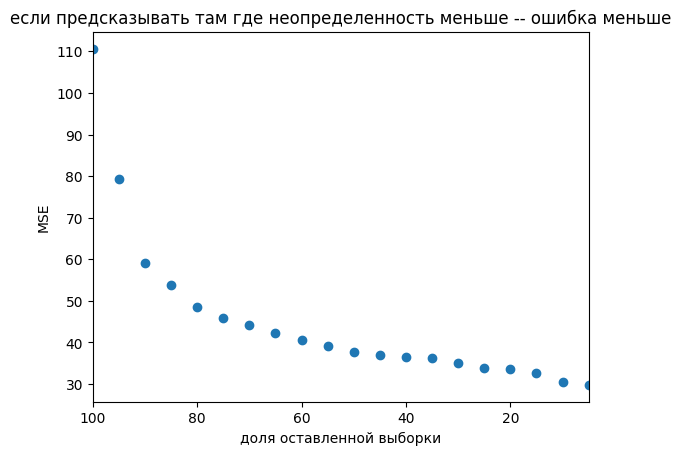

In [62]:
x_axis = np.linspace(5, 100, 20)
_ = plt.scatter(x_axis, mse)
plt.xlim(max(x_axis), min(x_axis))
plt.xlabel('доля оставленной выборки')
plt.ylabel('MSE')
plt.title('если предсказывать там где неопределенность меньше -- ошибка меньше')
plt.show()

Развитие подхода -- использовать не только оценку самого алгоритма, но и строить другую модель, которая на каждом семпле будет предсказывать ошибки текущей. Широко используется в банках как замена мониторинга моделей -- MPP

Например, в [статье](https://habr.com/ru/companies/vtb/articles/505892/) коллег из ВТБ

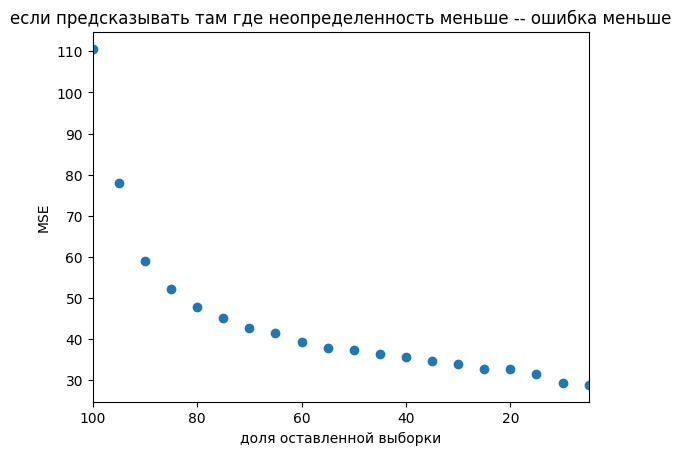

In [63]:
res['total_uncertaincy'] = res['data_uncertainty'] + res['knowledge_uncertainty']
number_unc_bins = 20
res['unc_bin_total'] = pd.qcut(res['total_uncertaincy'], number_unc_bins, labels = range(0, number_unc_bins))
mse_total = []
for tr in range(number_unc_bins):
  mse_total.append(mean_squared_error(res[res['unc_bin_total'] <= tr]['target'], res[res['unc_bin_total'] <= tr]['predictions']))
x_axis = np.linspace(5, 100, 20)
_ = plt.scatter(x_axis, mse_total)
plt.xlim(max(x_axis), min(x_axis))
plt.xlabel('доля оставленной выборки')
plt.ylabel('MSE')
plt.title('если предсказывать там где неопределенность меньше -- ошибка меньше')
plt.show()

# 3. Раз уж зашло про деревянные алгоритмы -- у них тоже есть особенности


немного про RF

In [64]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
n_features = 500
n_samples = 2000
data = make_classification(n_samples = n_samples, n_features =n_features, random_state = 42, n_redundant = n_features - n_features // 4)
df = pd.DataFrame(data[0], columns = [f'feature_{k}' for k in range(n_features)])
df['target'] = data[1]
df['feature_1'] = df['target'] + 0.5* df['feature_1']
df.rename(columns={'feature_1':'killer'}, inplace = True)

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [66]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('target', axis = 1), df['target'], test_size=0.33, random_state=42)

In [67]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(x_train, y_train,)
print(rf.score(x_test, y_test))

0.9515151515151515


In [68]:
from sklearn.tree import DecisionTreeClassifier

In [69]:
dtc = DecisionTreeClassifier(random_state=42)

In [70]:
dtc.fit(x_train, y_train)
print(dtc.score(x_test, y_test))

0.990909090909091


Почему единичное дерево лучше работает?

In [71]:
sorted([[col, imp] for imp, col in zip(rf.feature_importances_, \
                                       df.drop('target', axis = 1).columns)], key = lambda x :x[1], reverse=True)[0:5]

[['killer', 0.09535671897495712],
 ['feature_197', 0.027330275334180927],
 ['feature_324', 0.02708473592456345],
 ['feature_182', 0.02678941890217905],
 ['feature_437', 0.025746954477203696]]

In [72]:
sorted([[col, imp] for imp, col in zip(dtc.feature_importances_, \
                                       df.drop('target', axis = 1).columns)], key = lambda x :x[1], reverse=True)[0:5]

[['killer', 0.9210908320087833],
 ['feature_360', 0.05260854827649881],
 ['feature_86', 0.009594904103468391],
 ['feature_87', 0.00785978035708908],
 ['feature_370', 0.0029802588513088406]]

Почему так?
RF стоит на трех китах:

*   subsampling (выкидываем часть точек при построении очередного дерева),
*   subspacing (выкидываем часть фичей при построении очередного дерева),
*   voting (осредняем предикты всех деревьев)

Ситуации когда хорошая фича или важная группа сэмплов падает жертвой bagging / undersampling etc -- более чем частая


# 4. Фит-предикт -- путь к провалу

In [73]:
# !pip install catboost -q

In [76]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [77]:
np.random.seed(42)
n_samples = 10000

x = np.linspace(0, 10, n_samples).reshape(-1, 1)
y = 3 * np.sin(x) * x + 10 * x + np.random.normal(0, 0.5, size=(n_samples, 1))

df = pd.DataFrame({'feature': x.flatten(), 'target': y.flatten()})

df['feature'] = df['feature'] ** 2
x_train, x_test, y_train, y_test = train_test_split(df[['feature']], df['target'], test_size=0.2, random_state=42)

train_pool = Pool(x_train, y_train)

Кто-нибудь помнит как выбираются делаются сплиты?

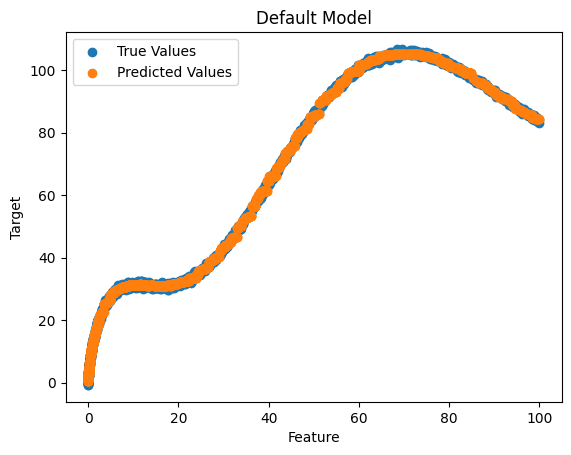

Default Model - Mean Squared Error: 0.47853450806524234


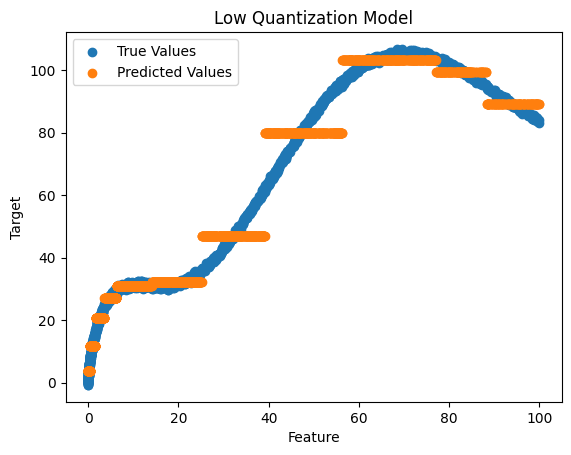

Low Quantization Model - Mean Squared Error: 24.644833954656363


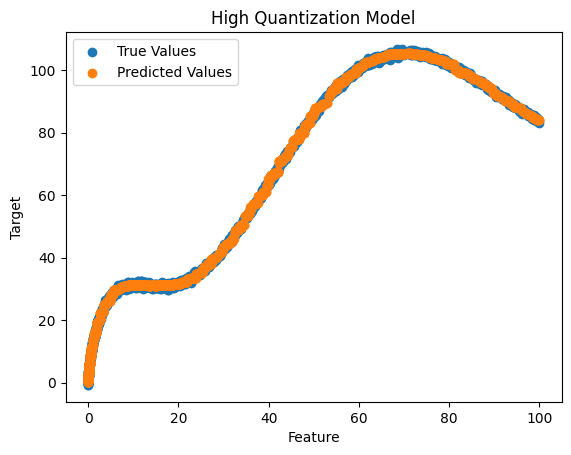

High Quantization Model - Mean Squared Error: 0.4175311130008739


In [78]:
catboost_params_default = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'RMSE',
}

catboost_params_custom_low_quantization = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'RMSE',
    'per_float_feature_quantization': ['0:border_count=10'],  # Low quantization
}

catboost_params_custom_high_quantization = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'RMSE',
    'per_float_feature_quantization': ['0:border_count=4096'],  # High quantization
}

models = []

model_default = CatBoostRegressor(**catboost_params_default)
model_default.fit(train_pool, verbose = False)
models.append(('Default', model_default))

model_low_quantization = CatBoostRegressor(**catboost_params_custom_low_quantization)
model_low_quantization.fit(train_pool, verbose = False)
models.append(('Low Quantization', model_low_quantization))

model_high_quantization = CatBoostRegressor(**catboost_params_custom_high_quantization)
model_high_quantization.fit(train_pool, verbose = False)
models.append(('High Quantization', model_high_quantization))

mse_array = {}

for model_name, model in models:
    y_pred = model.predict(x_test)

    plt.scatter(x_test, y_test, label='True Values')
    plt.scatter(x_test, y_pred, label='Predicted Values')
    plt.xlabel('Feature')
    plt.ylabel('Target')
    plt.title(f'{model_name} Model')
    plt.legend()
    plt.show()

    mse = mean_squared_error(y_test, y_pred)
    mse_array[model_name] = mse
    print(f'{model_name} Model - Mean Squared Error: {mse}')

Golden features? Quantization?

Это не про глубину деревьев и не про их число

In [79]:
round((1 - mse_array['High Quantization'] / mse_array['Default']) * 100)

13

На 13% уменьшили ошибку

---





[Пример когда дефолтное число сплитов сломало ценообразование на маркетплейсе](https://habr.com/ru/articles/760550/)



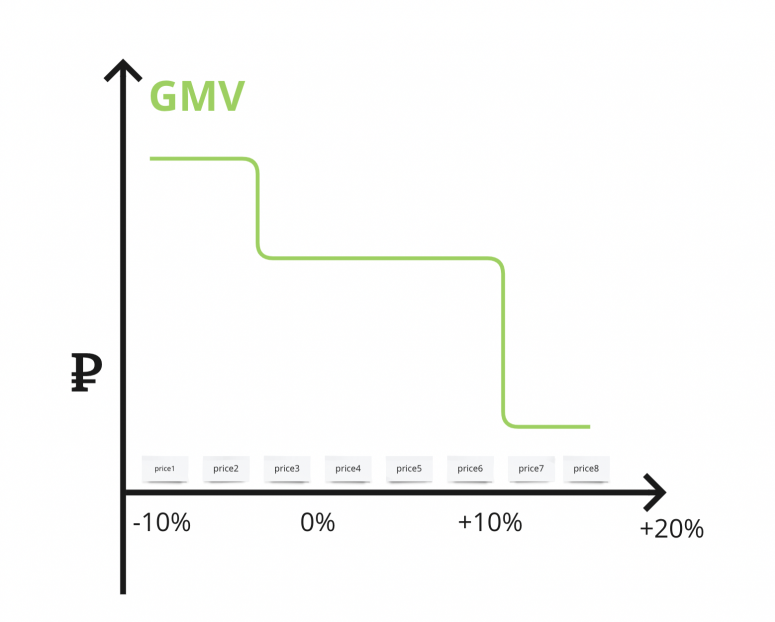

# 5. Как валидироваться

ML в бизнесе это в тч про то, чтобы деливерить стабильный прогнозируемый результат, и у каждой бизнес-задачи могут быть свои требования к проверке моделей перед их использованием.

В курсе мы подробно рассмотрим как в бизнес-задачах проверяют модель на

*   Переобученность
*   Стабильность во времени в смысле
    *   Data drift (часто называют Covariate shift)
    *   Concept Drift (posterior shift)
    *   Target shift (label shift, prior shift)
*   Соответсвие бизнес-логике и монотонным ограничениям
*   Интерпретируемость
*   Уверенность модели в ответе (uncertaincy и confidence)

а пока рассмотрим базовые подходы к валидации моделей  (с учетом что вы уже знаете про кросс-валидацию, метрики и отложенный тест)



## 5.1. Stratified vs group k-fold

In [82]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
np.random.seed(42)

In [83]:
x, y = make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=3,
    n_redundant=1,
    n_clusters_per_class=1,
    flip_y=0.1,
    random_state=42
)

num_groups = 10
group_ids = np.random.randint(num_groups, size=len(y))

data = pd.DataFrame(data={'feature_{}'.format(i): x[:, i] for i in range(x.shape[1])})
data['target'] = y
data['group_id'] = group_ids
cnt_dict = dict(data['group_id'].value_counts())
print(data.head())

   feature_0  feature_1  feature_2  feature_3  feature_4  target  group_id
0   0.798544   2.280978  -0.822322   0.288411  -3.418566       1         6
1   1.405951   0.664275   0.451591  -0.704822   0.577618       1         3
2  -1.964415   1.325393   0.827029   1.040189  -0.808016       0         7
3   1.792585   1.604088  -0.271690  -0.134156  -1.431986       1         4
4  -1.246207   0.364518   0.128635  -0.358704  -0.654848       1         6


Как правильно тестироваться?   
Группы постоянные (ex: Регионы)?   




Fold 1:
Training samples: 800
Testing samples: 200
Unique groups in training set: 10
Unique groups in testing set: 10

Fold 2:
Training samples: 800
Testing samples: 200
Unique groups in training set: 10
Unique groups in testing set: 10

Fold 3:
Training samples: 800
Testing samples: 200
Unique groups in training set: 10
Unique groups in testing set: 10

Fold 4:
Training samples: 800
Testing samples: 200
Unique groups in training set: 10
Unique groups in testing set: 10

Fold 5:
Training samples: 800
Testing samples: 200
Unique groups in training set: 10
Unique groups in testing set: 10


/opt/miniconda3/envs/mac_ker/lib/python3.12/site-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Text(0.5, 0.98, 'доли групп в трейне')

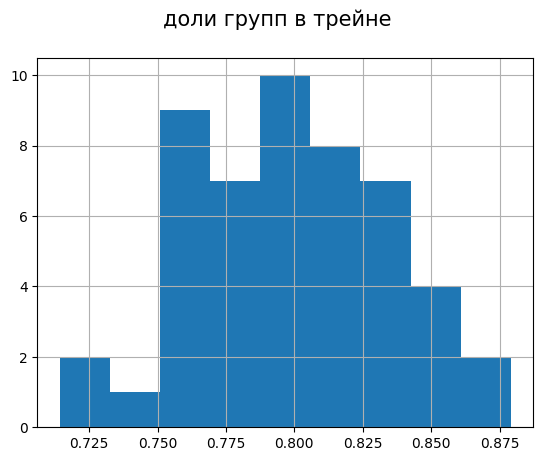

In [84]:
from sklearn.model_selection import StratifiedKFold
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ratios = []
for fold, (train_indices, test_indices) in enumerate(k_fold.split(x, y, group_ids)):
    print(f"\nFold {fold + 1}:")
    print(f"Training samples: {len(train_indices)}")
    print(f"Testing samples: {len(test_indices)}")
    print(f"Unique groups in training set: {len(np.unique(group_ids[train_indices]))}")
    print(f"Unique groups in testing set: {len(np.unique(group_ids[test_indices]))}")

    train_cnt_dict = dict(pd.Series(group_ids[train_indices]).value_counts())
    for group in train_cnt_dict:
      ratios.append(train_cnt_dict[group] * 1.0 / cnt_dict[group])
fig = plt.figure()
pd.Series(ratios).hist(bins = 9)
fig.suptitle('доли групп в трейне', fontsize=15)

Или на инференсе новая группа может придти (в ЖК есть корпуса а в них квартиры)?

In [88]:
from sklearn.model_selection import GroupKFold
k_fold = GroupKFold(n_splits=5)

for fold, (train_indices, test_indices) in enumerate(k_fold.split(x, y, group_ids)):
    print(f"\nFold {fold + 1}:")
    print(f"Training samples: {len(train_indices)}")
    print(f"Testing samples: {len(test_indices)}")
    print(f"Unique groups in training set: {len(np.unique(group_ids[train_indices]))}")
    print(f"Unique groups in testing set: {len(np.unique(group_ids[test_indices]))}")


Fold 1:
Training samples: 799
Testing samples: 201
Unique groups in training set: 8
Unique groups in testing set: 2

Fold 2:
Training samples: 799
Testing samples: 201
Unique groups in training set: 8
Unique groups in testing set: 2

Fold 3:
Training samples: 799
Testing samples: 201
Unique groups in training set: 8
Unique groups in testing set: 2

Fold 4:
Training samples: 799
Testing samples: 201
Unique groups in training set: 8
Unique groups in testing set: 2

Fold 5:
Training samples: 804
Testing samples: 196
Unique groups in training set: 8
Unique groups in testing set: 2


чтобы в явном виде задать сколько групп не включать в тексст -- [Leave P Groups Out](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.LeavePGroupsOut.html#sklearn.model_selection.LeavePGroupsOut)

## 5.2 Двойная кросс-валидация

Утащено [отсюда](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/)

In [89]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [90]:
%%time
random_state = 42
# create dataset
x, y = make_classification(n_samples=1000, n_features=20, random_state=1, n_informative=10, n_redundant=10)
# configure the cross-validation procedure
cv_inner = KFold(n_splits=3, shuffle=True, random_state=random_state)
# define the model
model = RandomForestClassifier(random_state=random_state)
# define search space
space = dict()
space['n_estimators'] = [10, 100]
space['max_features'] = [2, 4, 6]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=3, shuffle=True, random_state=1) # 10
# execute the nested cross-validation
scores = cross_val_score(search, x, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.927 (0.004)
CPU times: user 22.8 ms, sys: 82.7 ms, total: 105 ms
Wall time: 3.09 s


А вообще только в [2018](https://arxiv.org/abs/1809.09446) поставили точку в нужности такого приема (а их было много -- CV со взвешиваниями, со штрафами (V-Fold CV with penalty) и пр.)

## 5.3. Валидация с учетом времени

Простая схема с OOT
[отсюда](https://forecastegy.com/posts/time-series-cross-validation-python/)
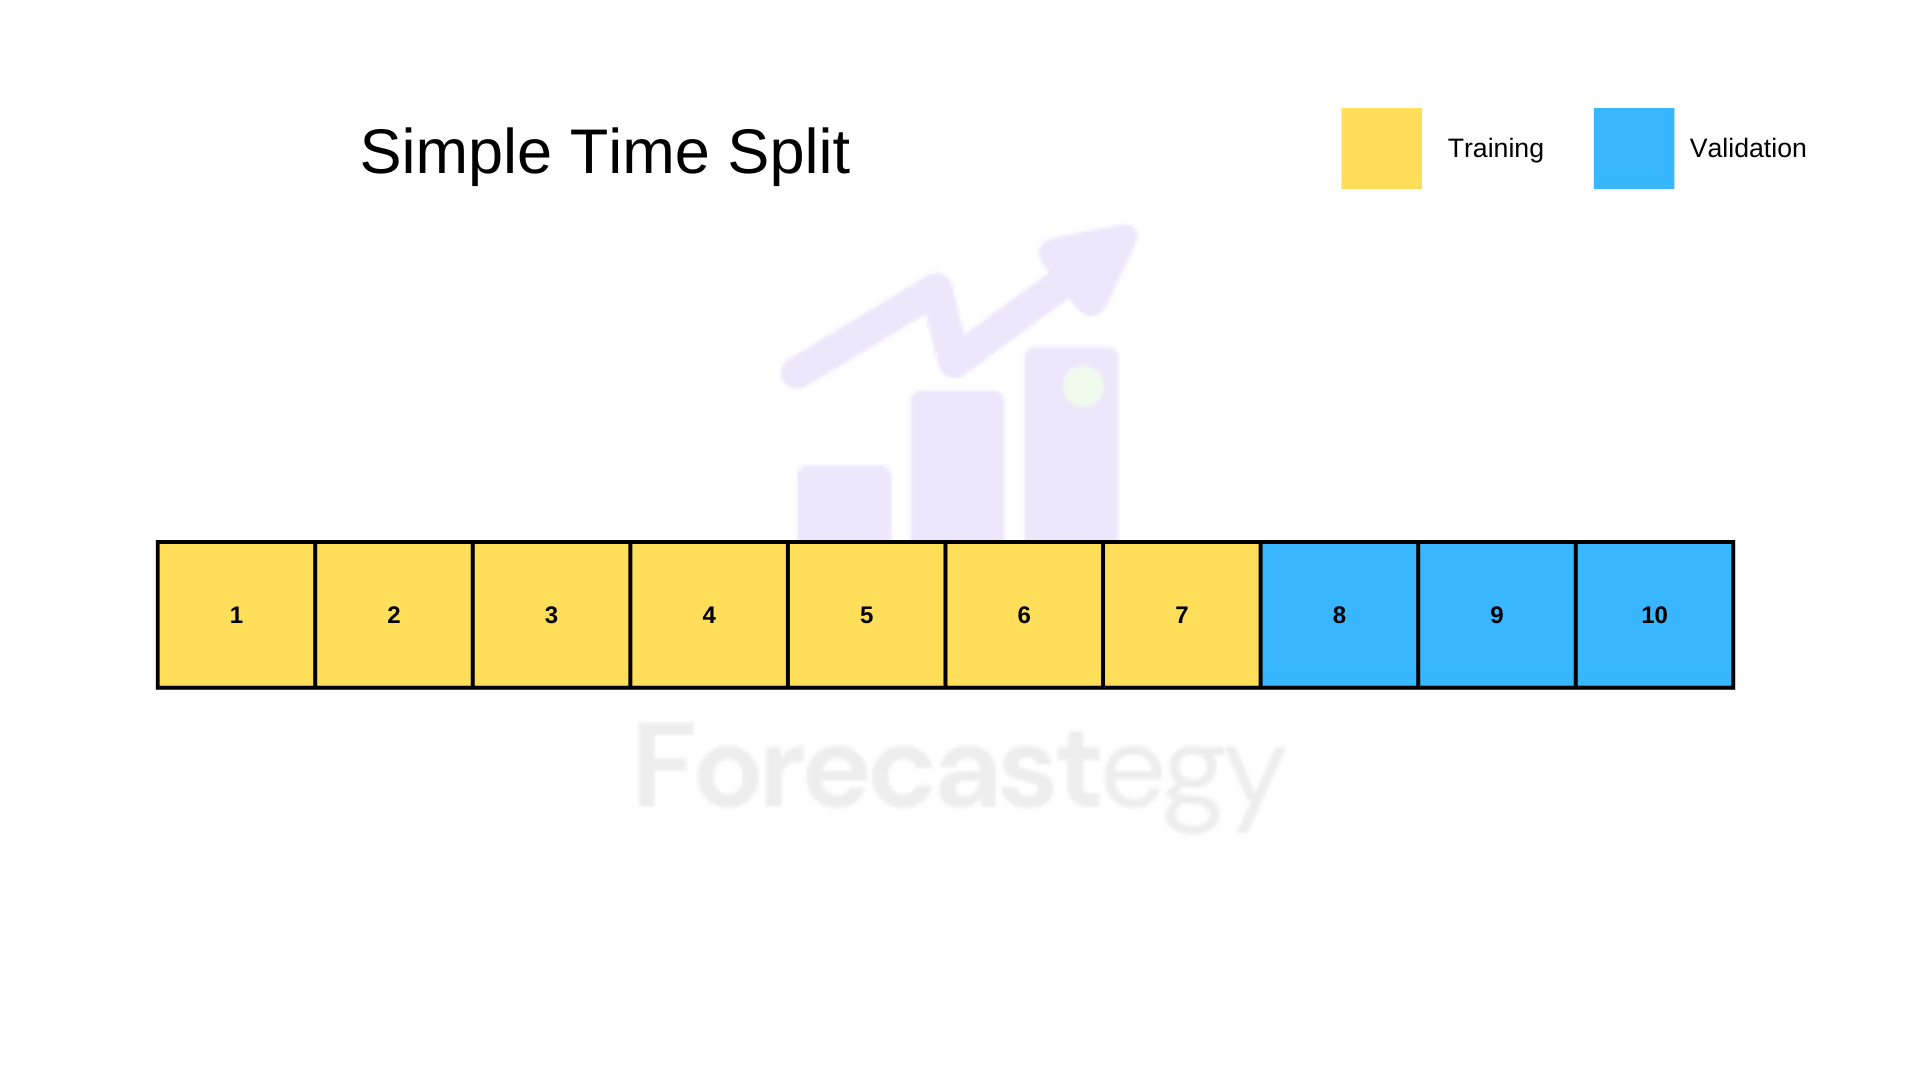

Схема скользящего окна
[отсюда](https://forecastegy.com/posts/time-series-cross-validation-python/)

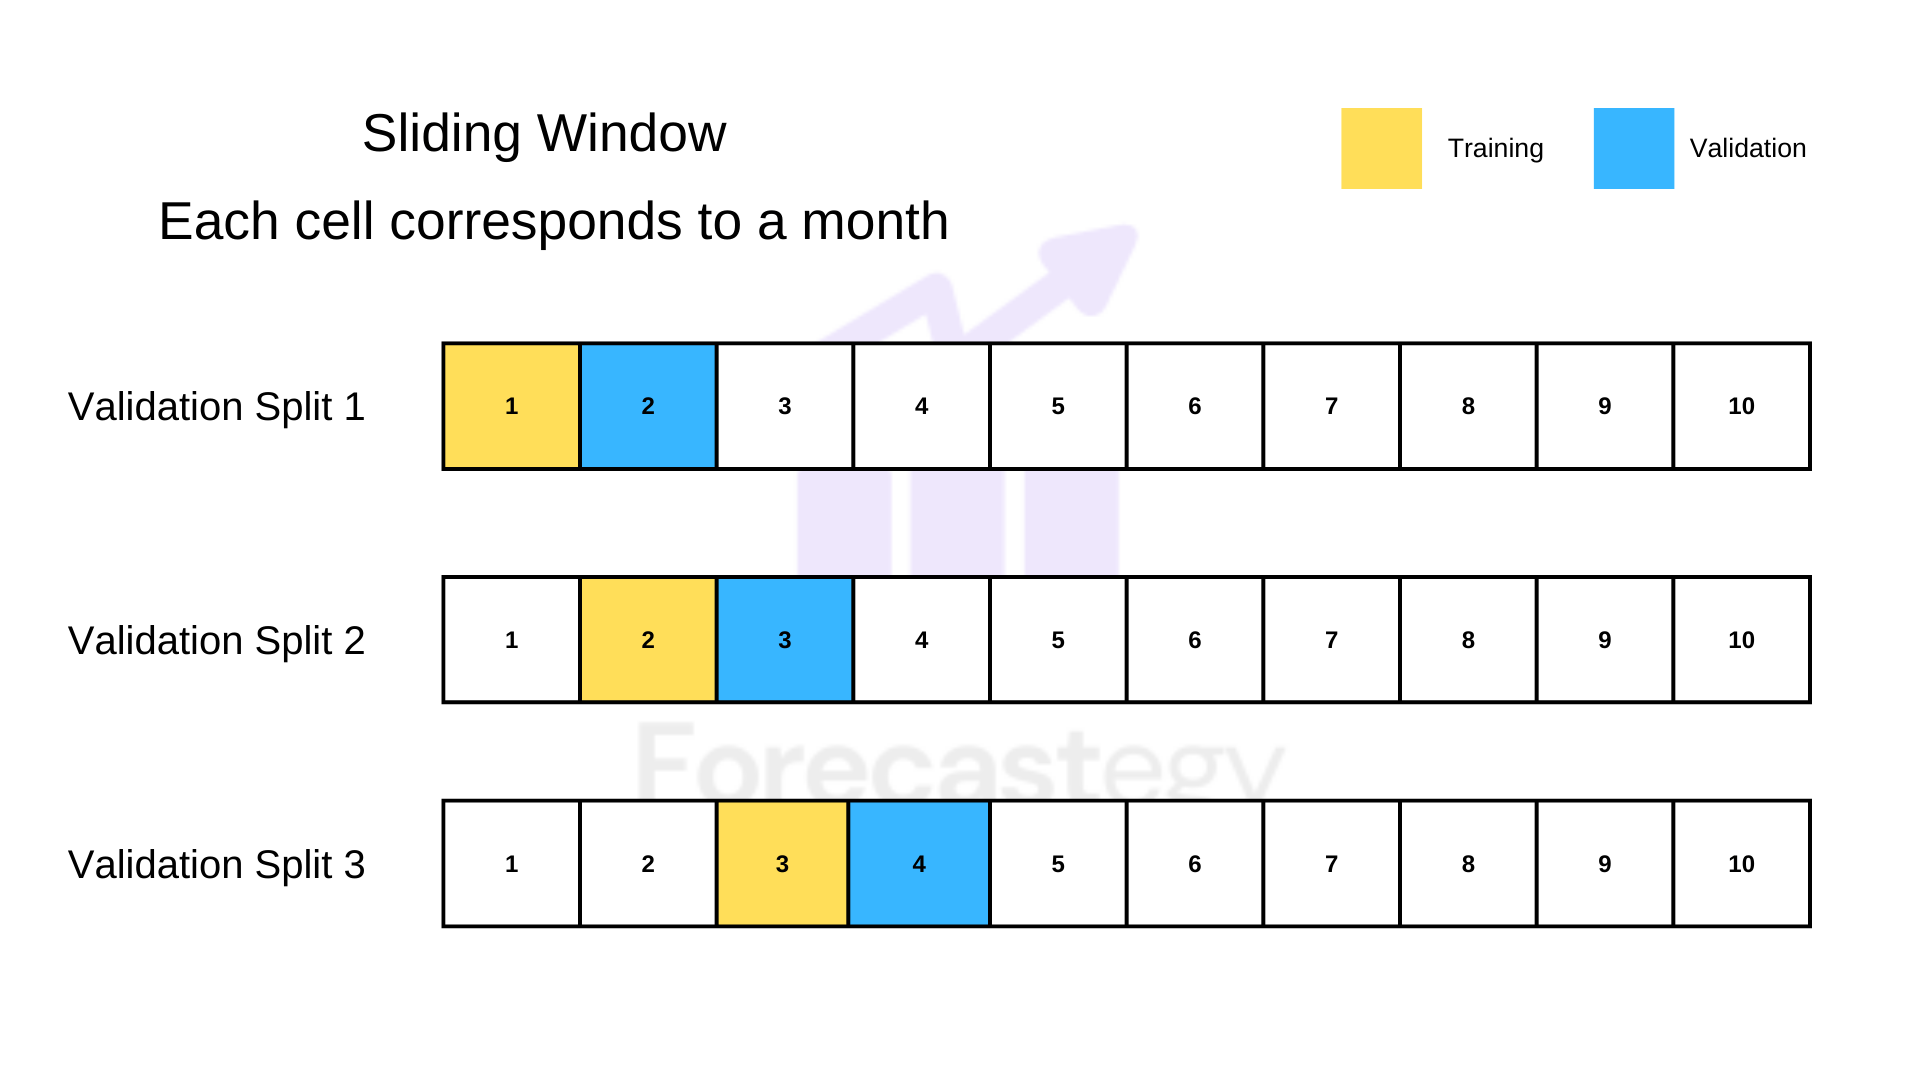

Схема расширяющегося скользящего окна
[отсюда](https://forecastegy.com/posts/time-series-cross-validation-python/)

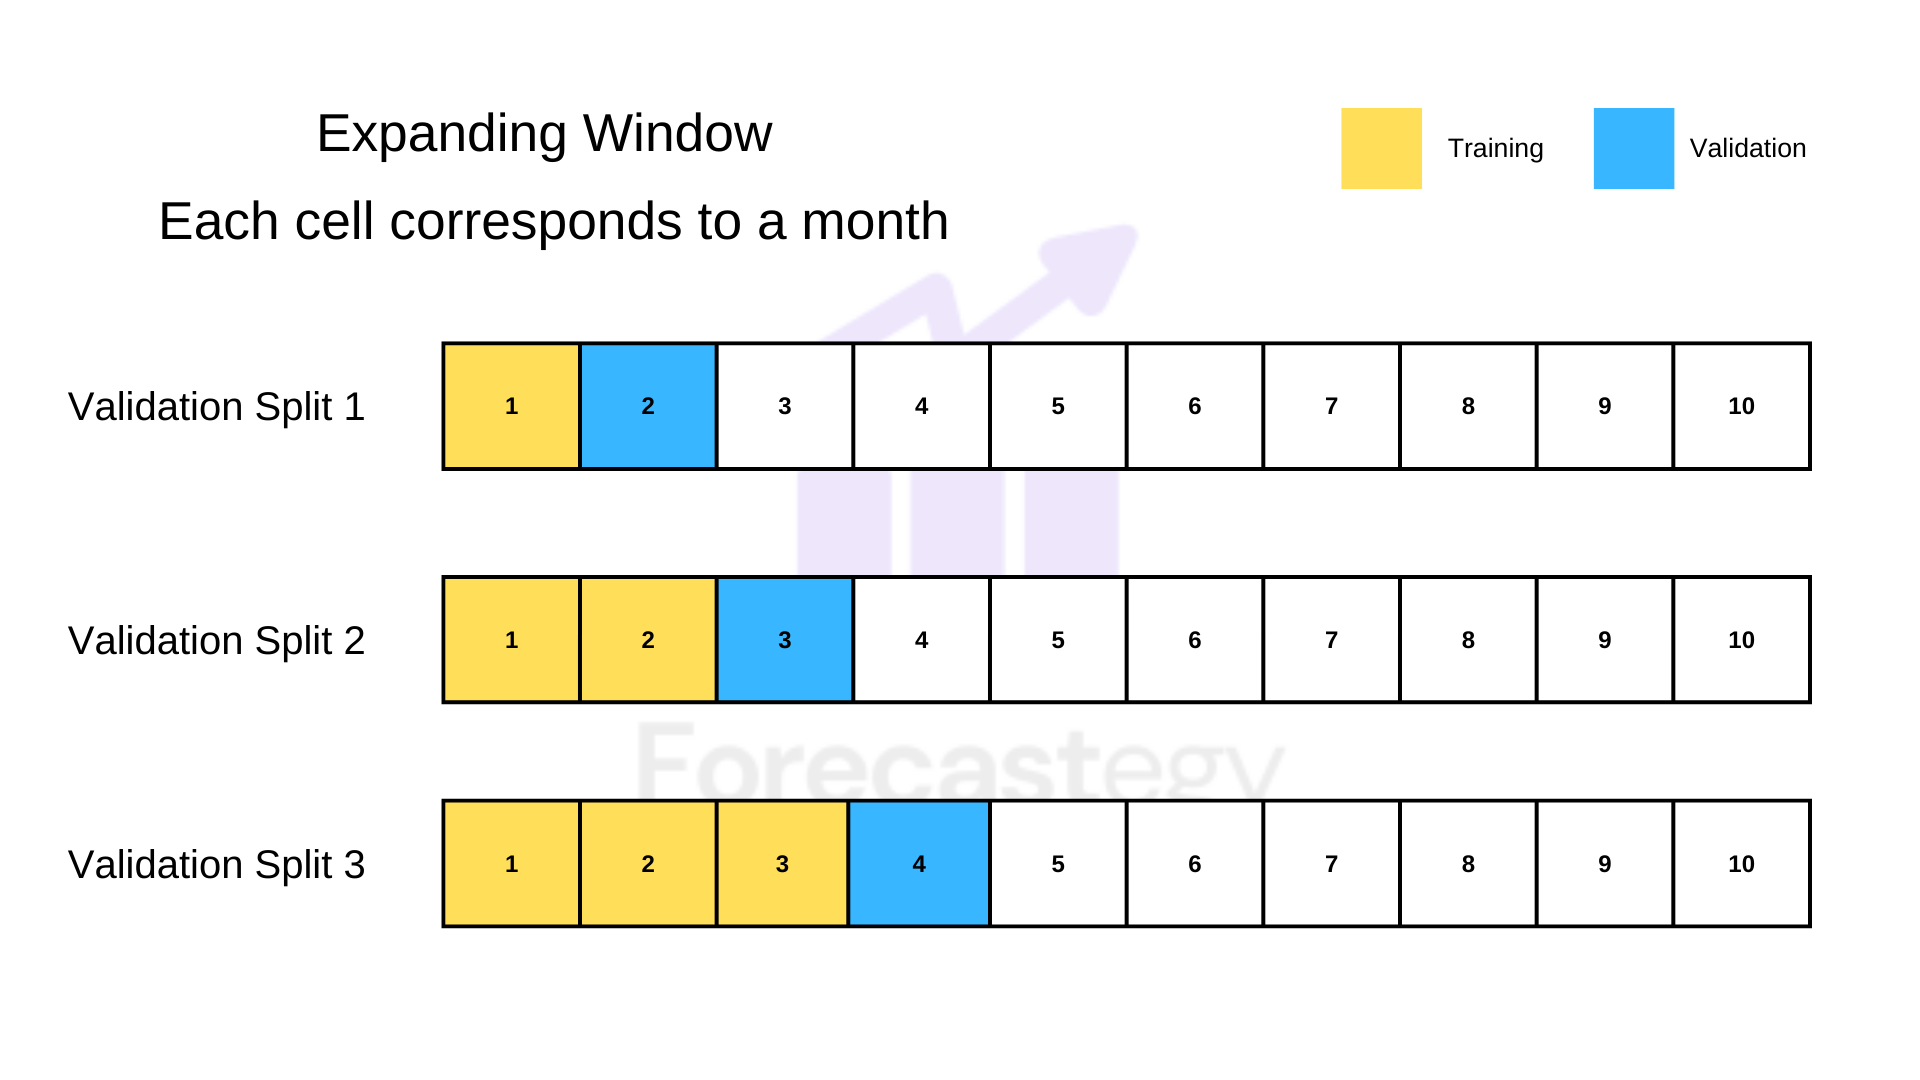

Схема скользящего окна с зазором
[отсюда](https://forecastegy.com/posts/time-series-cross-validation-python/)

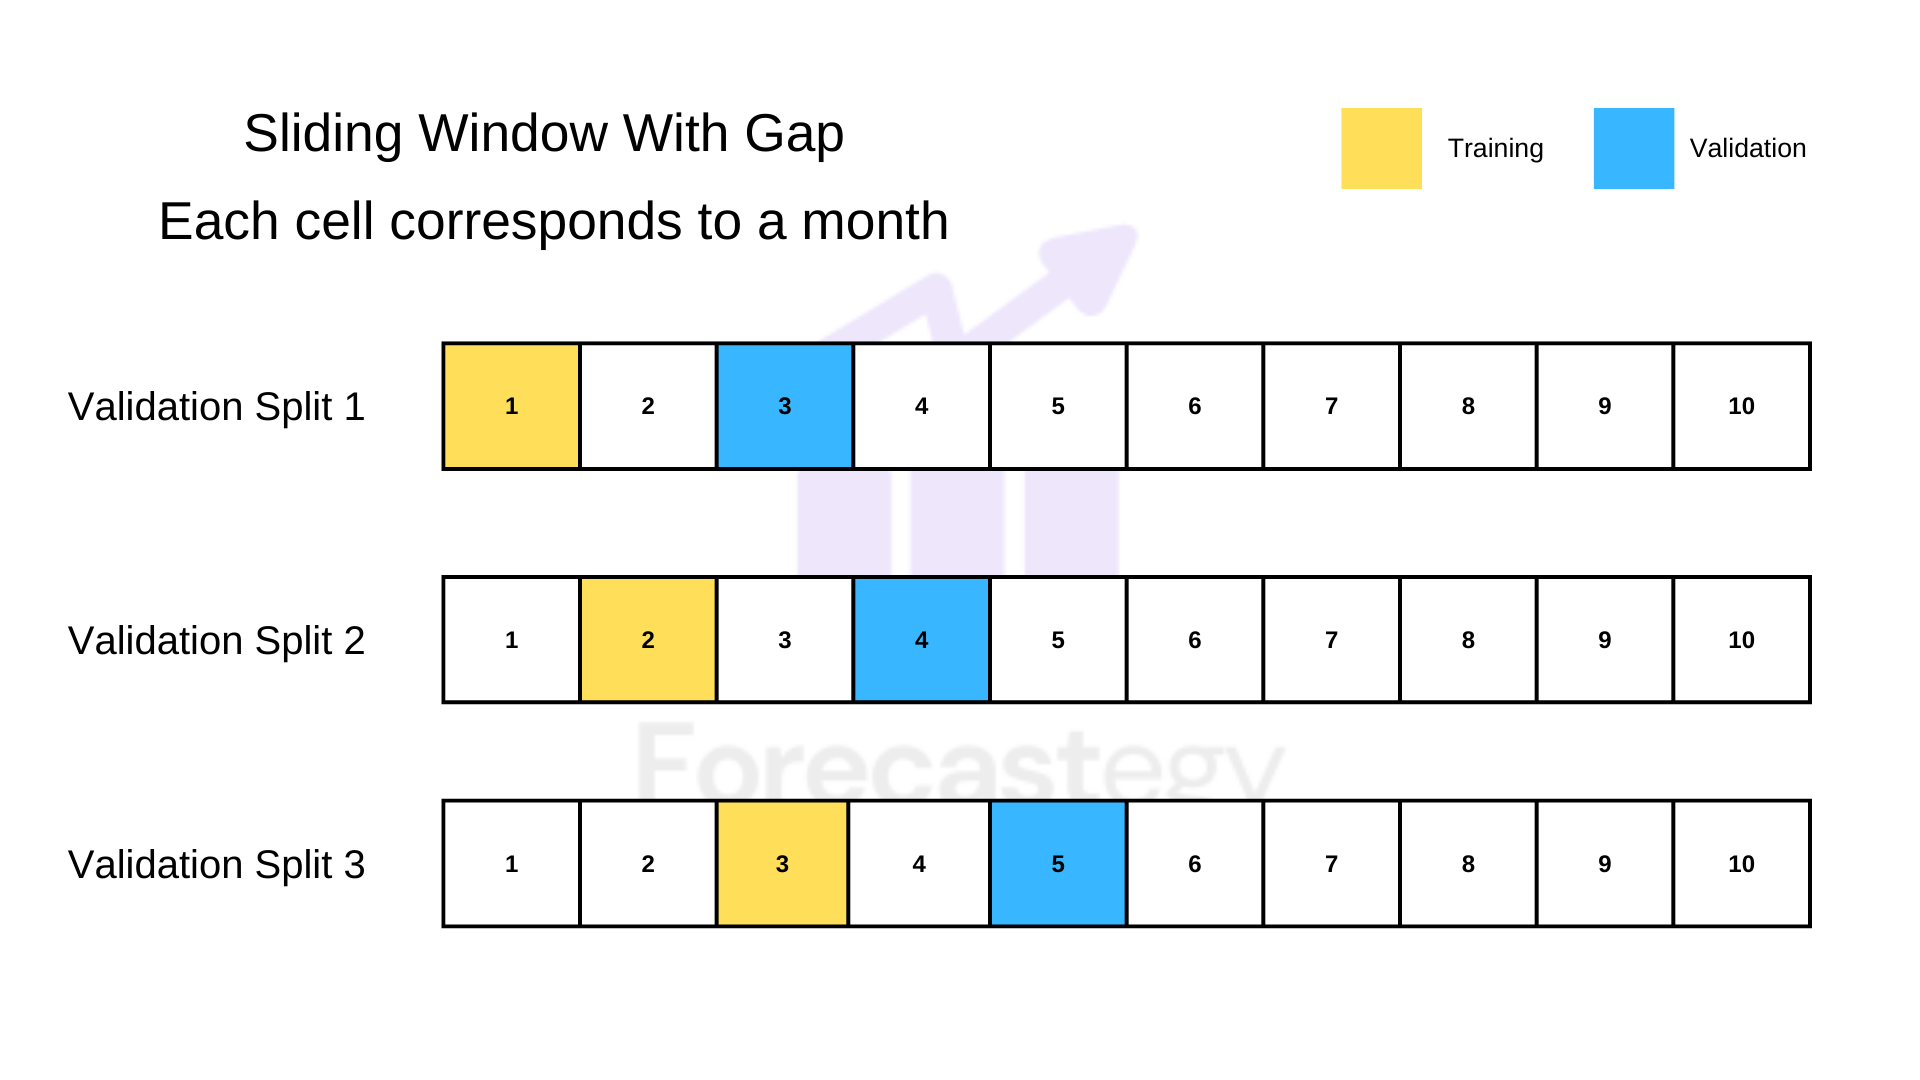

Какая схема чаще всего на практике?

Очень важно запомнить последнюю и всегда учитывать лаг источника как при сборке трейна, так и при валидации!

Параметр Gap уже появился и в sklearn в [TimeSeriesSplit](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)

## 5.4. Валидация двухэтапной модели

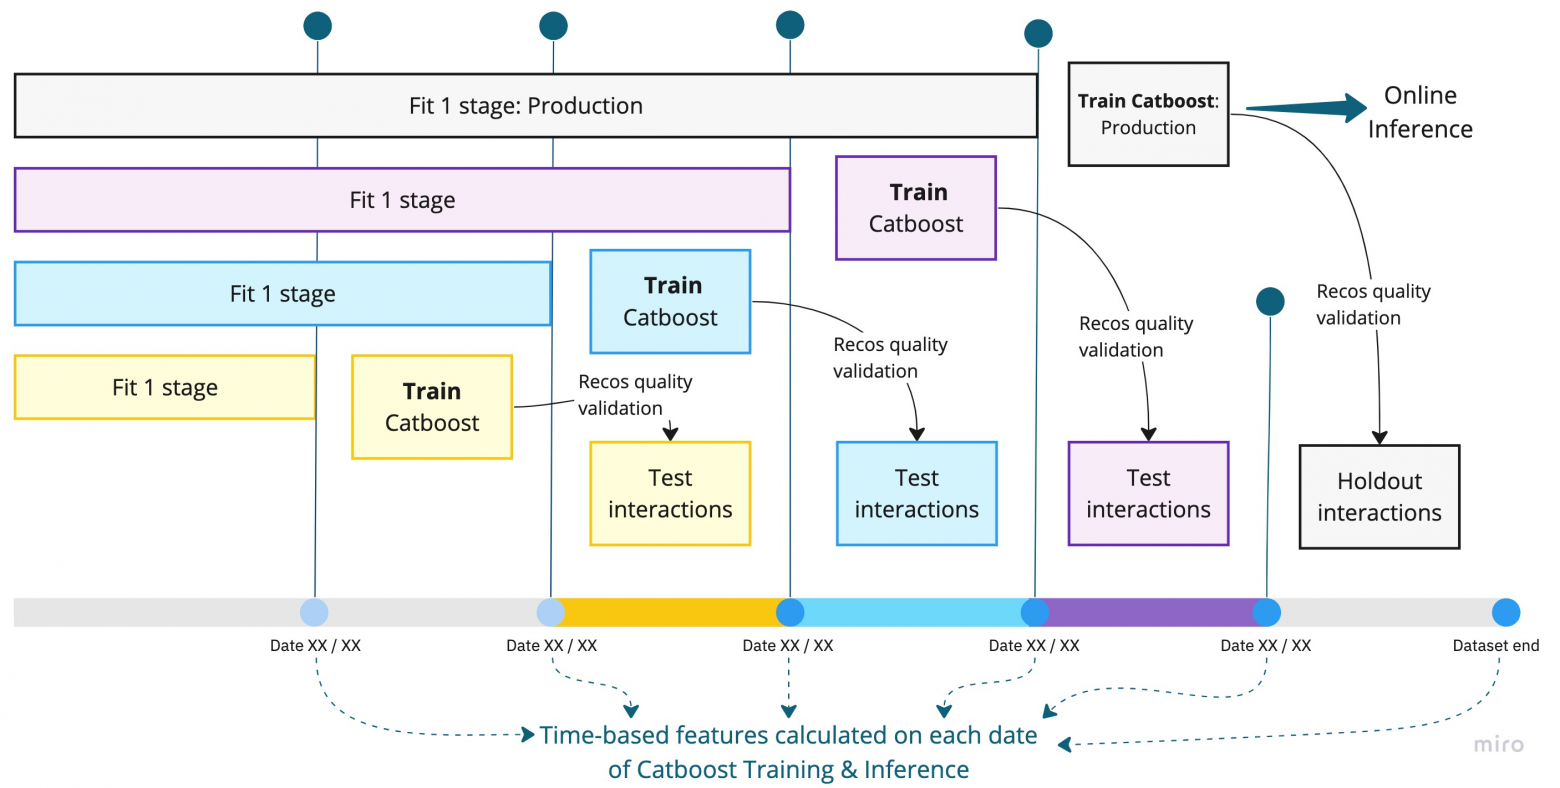


чуть детальнее про такие модели в рекомендациях [в блоге МТС на habr](https://habr.com/ru/companies/ods/articles/756874/)

## 5.5. Repeated k-fold

In [93]:
import lightgbm as lgb
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform
from sklearn.metrics import accuracy_score
from tqdm import tqdm

Пара экспериментов

### Эксперимент 1.

Разделим выборку на train и test.      
И на трейне будем через cv подбирать гиперпараметры, задав не по сетке всего один -- L2-регуляризию весов листьев в бустинге и подбирая его через RandomizedSearch.

Попробуем проверить, что произойдет с точностью модели если попробовать 200 разных random_state только для этой процедуры -- все остальное (разделение на train/test, сетка параметров и пр. -- абсолютно одинаковое)

In [ ]:
%%time
res_test_metrics = []
x, y = make_classification(n_samples=5000, n_features=20, random_state=1, n_informative=10, n_redundant=10)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

for random_state in tqdm(range(200)):
  bst = lgb.LGBMClassifier()
  hyper_space = dict(max_depth = [10, 15]
                    , n_estimators = [50, 100, 200]
                    , reg_lambda = uniform(), verbose = [-1], num_leaves=[32])
  clf = RandomizedSearchCV(bst, hyper_space, random_state=random_state)
  search = clf.fit(x_train, y_train)
  bst = lgb.LGBMClassifier(**search.best_params_)
  bst.fit(x_train, y_train)
  res_test_metrics.append(accuracy_score(bst.predict(x_test), y_test))
  print('accuracy ',  res_test_metrics[-1])

In [ ]:
print( min(res_test_metrics), max(res_test_metrics))
# 0.953 0.963

0.953 0.963


### Эксперимент 2

А теперь возьмем стандратный пайп обучения модели с разделением на отложенную выборку и подбором гиперпараметров через кросс-валидацию и начнем менять random_state для откладывания выборки.
Что произойдет с точностью модели?

In [ ]:
%%time
test_metrics_different_rs = []
for random_state in tqdm(range(200)):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = random_state)
  bst = lgb.LGBMClassifier()
  hyper_space = dict(max_depth = [10, 15]
                    , n_estimators = [50, 100, 200]
                    , reg_lambda = uniform(), verbose = [-1], num_leaves=[32])
  clf = RandomizedSearchCV(bst, hyper_space, random_state=42)
  search = clf.fit(x_train, y_train)
  bst = lgb.LGBMClassifier(**search.best_params_)
  bst.fit(x_train, y_train)
  test_metrics_different_rs.append(accuracy_score(bst.predict(x_test), y_test))
  print(test_metrics_different_rs[-1])

In [ ]:
print( min(test_metrics_different_rs), max(test_metrics_different_rs))
# 0.937 0.97

0.937 0.97


чтобы сделать k-fold еще более случайным придумали repeated k-fold

### Repeated K-Fold

Если хочется оценить разброс быстрее -- можно добавить побольше рандомизаций !

In [95]:
from sklearn.model_selection import RepeatedKFold

In [96]:
%%time
res2_test_metrics = []
x, y = make_classification(n_samples=5000, n_features=20, random_state=1, n_informative=10, n_redundant=10)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
rkf = RepeatedKFold(n_splits=5, n_repeats=4, random_state=2652124)
random_state = 43
rkf.get_n_splits(x_train, y_train)
bst = lgb.LGBMClassifier(verbose = [-1])
for i, (train_index, test_index) in enumerate(rkf.split(x_train)):
  bst.fit(x_train[train_index], y_train[train_index])
  res2_test_metrics.append(accuracy_score(bst.predict(x_train[test_index]), y_train[test_index]))
  res2_test_metrics.append(accuracy_score(bst.predict(x_test), y_test))

CPU times: user 8.04 s, sys: 17.1 s, total: 25.2 s
Wall time: 11.2 s


In [97]:
min(res2_test_metrics), max(res2_test_metrics)

(0.92875, 0.95875)

## 5.6. Как оценить качество модели на трейне? Out of fold валидация

Сейчас мы рассмотрим прием, связанный с оценкой качества модели на **трейне**

Сначала построим модель и оценим ее качество на **тесте**

In [98]:
import lightgbm as lgb
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [99]:
res_test_metrics = []
random_state = 123
x, y = make_classification(n_samples=5000, n_features=20, random_state=random_state, n_informative=10, n_redundant=10)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)

bst = lgb.LGBMClassifier()
hyper_space = dict(max_depth = [10, 15]
                    , n_estimators = [50, 100, 200]
                    , reg_lambda = uniform(), verbose = [-1], num_leaves=[32])
clf = RandomizedSearchCV(bst, hyper_space, random_state=random_state)
search = clf.fit(x_train, y_train)
bst = lgb.LGBMClassifier(**search.best_params_)
bst.fit(x_train, y_train)
print(accuracy_score(bst.predict(x_test), y_test))

0.953


как часто (и редко когда оправданно) оценивают качество ошибки на трейне:

In [101]:
print(accuracy_score(bst.predict(x_train), y_train))

1.0


Понятно, что бустинг склонен к переобучению, но даже достаточно загрубленный бустинг выдал бы оценку точности сильно выше, чем на тесте. Как же получить относительно честную оценку качества на трейне?

In [102]:
import pandas as pd
x_train_df = pd.DataFrame(x_train)
y_train_df = pd.Series(y_train)

In [103]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
predictions = []
for cv_train_idx, cv_test_idx in kf.split(x_train):
  bst = lgb.LGBMClassifier(**search.best_params_)
  bst.fit(x_train[cv_train_idx], y_train[cv_train_idx])
  if len(predictions) == 0:
    predictions = pd.DataFrame(bst.predict(x_train[cv_test_idx]), index = cv_test_idx)
  else:
    predictions = pd.concat([predictions, pd.DataFrame(bst.predict(x_train[cv_test_idx]), index = cv_test_idx)])

In [104]:
print(accuracy_score(predictions.sort_index(), y_train_df.sort_index()))

0.94875


Вот этот Out of fold скор часто называют оценкой качества модели на трейне

Но есть нюанс -- посмотрим на индексы, которые дает KFold:

In [105]:
cv_test_idx

array([3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210,
       3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221,
       3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232,
       3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243,
       3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254,
       3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265,
       3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276,
       3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287,
       3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298,
       3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309,
       3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320,
       3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331,
       3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342,
       3343, 3344, 3345, 3346, 3347, 3348, 3349, 33

Они идут подряд!!!

Это, кстати, позволит обойтись **без Pandas** в этом коде)

Однако, [Shuffle Split](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit) здесь только навредит -- какие-то индексы могут вообще не попасть в тест ни разу, а какие-то дважды.

Так что если хотите пермешать данные -- лучше сделать это один раз до OOF оценки

Теперь давайте сравним перфоманс **на тесте** одной модели и пяти (c OOF):

In [106]:
# модель, обученная на всем трейне
bst = lgb.LGBMClassifier(**search.best_params_)
bst.fit(x_train, y_train)
print(accuracy_score(bst.predict(x_test), y_test))

0.953


In [107]:
# осредняем предикты пяти OOF-моделей
oof_models = []
predictions = np.zeros(len(y_test))
for cv_train_idx, cv_test_idx in kf.split(x_train):
  bst = lgb.LGBMClassifier(**search.best_params_)
  bst.fit(x_train[cv_train_idx], y_train[cv_train_idx])
  oof_models.append(bst)
  predictions = predictions + bst.predict_proba(x_test)[:, 1]
predictions /= len(oof_models)
print(accuracy_score(pd.Series(predictions).map(round), y_test))

0.955


Вот за эти 0.2% accuracy идет суровая борьба на Kaggle)

# Summary


1.   Границы применимости модели -- что при экстраполяции что при интерполяции сложные модели очень быстро теряют обобщающую способность, скорость этой потери нужно контролировать
2.   Не верим курсам где говорят что все прекрасно работает "из коробки". Бесплатных обедов не бывает
3. Проверить работу модели даже в офлайн -- это совсем не про то что "посчитаю метрику на hold-out"
4. Вы познакомили с OOT (out of time), OOS (out of sample) и OOF (out of fold) валидациями


# Домашнее задание

# RQ1: поможет ли feature selection хотя бы частично снизить дисперсию метрики качества?

Напишите код чтобы проверить гипотезу что feature selection частично нивелирует эффект из примера (Эксперимент 2) -- станет ли итоговая оценка точности модели меньше зависиеть от random seed с которым отложили тестовую выбрку?

Варианты ответа:
*   Дисперсия оценки метрики уменьшится
*   Дисперсия оценки метрики статистически не изменится



In [11]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
from scipy.stats import levene
from catboost import CatBoostRegressor, Pool
import statistics as st
import matplotlib.pyplot as plt

In [12]:
GLOBAL_SEED = 42

# параметры эксперимента
N_SAMPLES          = 20_000 # значение из эксперимента 2
N_INFORMATIVE      = 10 # действительно влияющие фичи
N_NOISE            = 50 # чистый шум, чтобы эффект FS был заметен
N_TOTAL_FEATS      = N_INFORMATIVE + N_NOISE
NOISE              = 5.0
RANDOM_SPLIT_SEEDS = range(100)
TEST_SIZE          = 0.3 # значение из эксперимента 2
VAL_SIZE           = 0.2 # значение из эксперимента 2
TOP_K              = 10 # сколько фичей оставить после SelectKBest
CAT_CFG            = dict(
    loss_function='RMSE',
    random_seed=GLOBAL_SEED,
    depth=8,
    learning_rate=0.1,
    l2_leaf_reg=3,
    iterations=500,
    verbose=False
)

In [13]:
def create_dataset(n_samples, n_total_feats, n_informative, noise, random_state):
    # создаём данные: informative + Gaussian noise
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_total_feats,
        n_informative=n_informative,
        noise=noise,
        random_state=random_state
    )
    feature_names = [f'feature_{i}' for i in range(n_total_feats)]
    df = pd.DataFrame(X, columns=feature_names)
    df['target'] = y

    return df


def get_splits(df, seed):
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop('target', axis=1), df['target'],
        test_size=TEST_SIZE, random_state=seed)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=VAL_SIZE, random_state=seed)

    return X_train, X_test, X_val, y_train, y_test, y_val


def eval_split_default(df, seed):
    X_train, X_test, X_val, y_train, y_test, y_val = get_splits(df, seed)

    # CatBoost train
    train_pool = Pool(X_train, y_train)
    val_pool   = Pool(X_val, y_val)
    model = CatBoostRegressor(
        loss_function='RMSE', posterior_sampling=True,
        verbose=False, random_seed=seed
    )
    model.fit(train_pool, eval_set=val_pool, verbose = False)

    # оценка
    rmse = mean_squared_error(y_test, model.predict(X_test))
    return rmse


def eval_split_selection(df, seed, use_fs=False, top_k=TOP_K):
    X_train, X_test, X_val, y_train, y_test, y_val = get_splits(df, seed)
    
    # optional feature selection (fit только на трейне!)
    if use_fs:
        # idx_test = X_test.index
        selector = SelectKBest(f_regression, k=top_k).fit(X_train, y_train)
        X_train = selector.transform(X_train)
        X_val   = selector.transform(X_val)
        X_test  = selector.transform(X_test)
        # X_test = pd.DataFrame(X_test, index=idx_test, 
                    #   columns=selector.get_feature_names_out())

    # CatBoost train
    train_pool = Pool(X_train, y_train)
    val_pool   = Pool(X_val, y_val)
    model = CatBoostRegressor(
        loss_function='RMSEWithUncertainty', posterior_sampling=True,
        verbose=False, random_seed=42
    )
    model.fit(train_pool, eval_set=val_pool)
    preds = model.virtual_ensembles_predict(X_test, prediction_type='TotalUncertainty',
                                        virtual_ensembles_count=10)
    res = pd.DataFrame(preds, columns = ['predictions', 'knowledge_uncertainty', 'data_uncertainty'], index = y_test.index)
    res['target'] = y_test
    rmse_u = mean_squared_error(res['target'], res['predictions'])
    return rmse_u

Повторим результаты из эксперимента 2:

In [14]:
df = create_dataset(N_SAMPLES, 10, 10, noise=0, random_state=GLOBAL_SEED)
rmse_raw_ex2 = eval_split_default(df, 42)
rmse_fs_ex2  = eval_split_selection(df, 42, use_fs=False)

print('Повторение результатов из эксперимента 2:\n')

print(f'RMSE без FS: {rmse_raw_ex2}')
print(f'RMSE с FS:   {rmse_fs_ex2}\n')

print(f'Эффект RMSEWithUncertainty на одном сплите: {rmse_raw_ex2 / rmse_fs_ex2}')


Повторение результатов из эксперимента 2:

RMSE без FS: 87.2493084202163
RMSE с FS:   110.60808659036958

Эффект RMSEWithUncertainty на одном сплите: 0.7888149149830146


Повторим этот эксперимент многократно, чтобы сделать эффект более наглядным:

In [15]:
rmse_raw_0 = [
    eval_split_default(
        create_dataset(N_SAMPLES, 10, 10, noise=0, random_state=seed), 
        seed
        ) for seed in RANDOM_SPLIT_SEEDS
    ]
rmse_fs_0  = [
    eval_split_selection(
        create_dataset(N_SAMPLES, 10, 10, noise=0, random_state=seed), 
        seed, 
        use_fs=False
        ) for seed in RANDOM_SPLIT_SEEDS
    ]

print(f'RMSE без FS: {st.mean(rmse_raw_0):.3f} ± {st.stdev(rmse_raw_0):.3f}')
print(f'RMSE с FS:   {st.mean(rmse_fs_0):.3f} ± {st.stdev(rmse_fs_0):.3f}\n')

print(f'Эффект RMSEWithUncertainty на {len(RANDOM_SPLIT_SEEDS)} сплитах: {st.mean(rmse_fs_0) / st.mean(rmse_raw_0):.3f}')


RMSE без FS: 71.994 ± 27.838
RMSE с FS:   98.397 ± 39.039

Эффект RMSEWithUncertainty на 100 сплитах: 1.367


Теперь проведём 2 эксперимента, с большим количеством фичей. Первый раз без `SelectKBest`, второй - с использованием `SelectKBest`

In [16]:
rmse_raw = [
    eval_split_default(
        create_dataset(N_SAMPLES, N_TOTAL_FEATS, N_INFORMATIVE, noise=0, random_state=seed),
        seed
        ) for seed in RANDOM_SPLIT_SEEDS
    ]
mean_raw, std_raw = st.mean(rmse_raw), st.stdev(rmse_raw)

rmse_fs_1  = [
    eval_split_selection(
        create_dataset(N_SAMPLES, N_TOTAL_FEATS, N_INFORMATIVE, noise=0, random_state=seed),
        seed, 
        use_fs=False
        ) for seed in RANDOM_SPLIT_SEEDS
    ]
mean_fs_1,  std_fs_1  = st.mean(rmse_fs_1),  st.stdev(rmse_fs_1)
p_levene_1 = levene(rmse_raw, rmse_fs_1).pvalue  # сравнение дисперсий

rmse_fs_2  = [
    eval_split_selection(
        create_dataset(N_SAMPLES, N_TOTAL_FEATS, N_INFORMATIVE, noise=0, random_state=seed),
        seed, 
        use_fs=True
        ) for seed in RANDOM_SPLIT_SEEDS
    ]
mean_fs_2,  std_fs_2  = st.mean(rmse_fs_2),  st.stdev(rmse_fs_2)
p_levene_2 = levene(rmse_raw, rmse_fs_2).pvalue  # сравнение дисперсий

In [17]:
print(f'Эксперимент с {N_TOTAL_FEATS} фичами, из которых {N_INFORMATIVE} являются информативными.\n')

print(f"Без FS : RMSE                = {mean_raw:.3f} ± {std_raw:.3f}")
print(f"Без FS : RMSEWithUncertainty = {mean_fs_1 :.3f} ± {std_fs_1 :.3f}\n")

print(f"Levene p-value для дисперсий: {p_levene_1:.4f}\n")

print(f'Эффект RMSEWithUncertainty на {len(RANDOM_SPLIT_SEEDS)} попытках: {st.mean(rmse_fs_1) / st.mean(rmse_raw):.3f}')

Эксперимент с 60 фичами, из которых 10 являются информативными.

Без FS : RMSE                = 77.863 ± 25.046
Без FS : RMSEWithUncertainty = 106.296 ± 36.976

Levene p-value для дисперсий: 0.0006

Эффект RMSEWithUncertainty на 100 попытках: 1.365


In [18]:
print(f'Эксперимент с {N_TOTAL_FEATS} фичами, из которых {N_INFORMATIVE} являются информативными.\nSelectKBest отбирает {TOP_K} фичей для каждого сплита.\n')

print(f"Без FS : RMSE                = {mean_raw:.3f} ± {std_raw:.3f}")
print(f"С   FS : RMSEWithUncertainty = {mean_fs_2 :.3f} ± {std_fs_2 :.3f}\n")

print(f"Levene p-value для дисперсий: {p_levene_2:.4f}\n")

print(f'Эффект RMSEWithUncertainty на {len(RANDOM_SPLIT_SEEDS)} попытках: {st.mean(rmse_fs_2) / st.mean(rmse_raw):.3f}')

Эксперимент с 60 фичами, из которых 10 являются информативными.
SelectKBest отбирает 10 фичей для каждого сплита.

Без FS : RMSE                = 77.863 ± 25.046
С   FS : RMSEWithUncertainty = 97.269 ± 31.288

Levene p-value для дисперсий: 0.0844

Эффект RMSEWithUncertainty на 100 попытках: 1.249


/var/folders/pm/2xw0rrzs5gz6r8wz7rr295qc0000gn/T/ipykernel_6059/1081257865.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rmse_raw_1, rmse_fs_1], labels=['No FS', 'Without FS'])


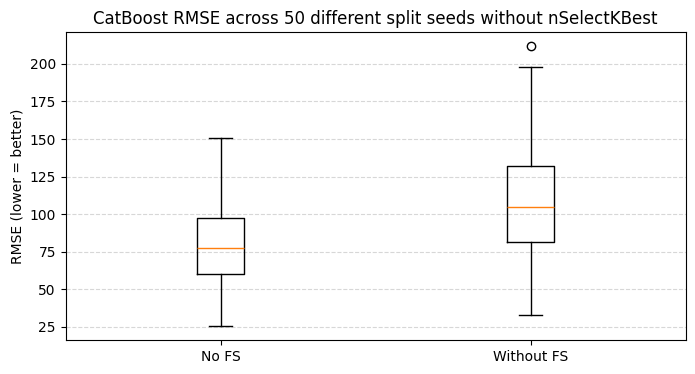

In [10]:
plt.figure(figsize=(8, 4))
plt.boxplot([rmse_raw, rmse_fs_1], labels=['No FS', 'Without FS'])
plt.title(f'CatBoost RMSE across {len(RANDOM_SPLIT_SEEDS)} different split seeds without nSelectKBest')
plt.ylabel('RMSE (lower = better)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

/var/folders/pm/2xw0rrzs5gz6r8wz7rr295qc0000gn/T/ipykernel_6059/1953306665.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rmse_raw_2, rmse_fs_2], labels=['No FS', 'With FS'])


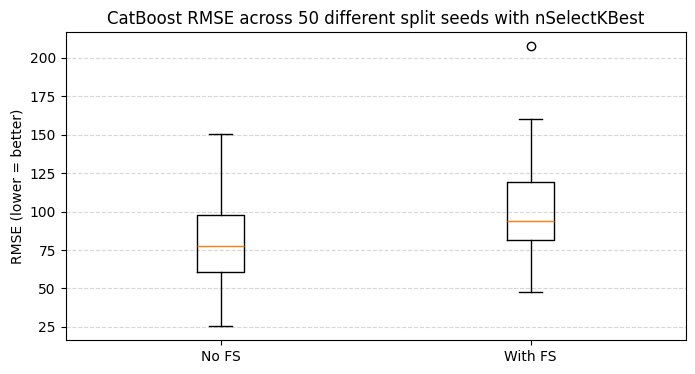

In [11]:
plt.figure(figsize=(8, 4))
plt.boxplot([rmse_raw, rmse_fs_2], labels=['No FS', 'With FS'])
plt.title(f'CatBoost RMSE across {len(RANDOM_SPLIT_SEEDS)} different split seeds with nSelectKBest')
plt.ylabel('RMSE (lower = better)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

**Вывод:**

Использование feature selection (`SelectKBest`) повысило среднюю точность модели с `RMSEWithUncertainty`. И помогло снизить итоговый разброс оценки качества модели.
Ответ: **Дисперсия оценки метрики уменьшится**

# RQ2: представьте что вы согласовали с вашим PO возможность применения модели на инференсе не для всей выборки. Решите любую задачу регрессии и постройте график зависимости точности (например, MDAPE) от доли выборки, в которой uncertaincy модели меньше порога (меняя порог)

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

Параметры симуляции и самой модели

In [50]:
N_SAMPLES     = 8000
N_FEATURES    = 20
TEST_SIZE     = 0.3
RANDOM_STATES = range(20)
MODEL_CFG     = dict(
    n_estimators=500,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
)
data = fetch_california_housing(as_frame=True)
def mdape(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:

X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=0
)

In [ ]:
rf = RandomForestRegressor(**MODEL_CFG).fit(X_train, y_train)
# Получаем предсказания
all_preds = np.stack([t.predict(X_test) for t in rf.estimators_])
y_hat     = all_preds.mean(axis=0)
sigma     = all_preds.std(axis=0) # proxy-uncertainty

Для 19 квантилей:  
- Берём «уверенные» точки (дисперсия <= порог).  
- Считаем coverage и MDAPE.  
Получаем два списка для графика.

In [55]:
print(f"Baseline MDAPE (coverage=1): {mdape(y_test, y_hat):.2f}%")

Baseline MDAPE (coverage=1): 12.21%


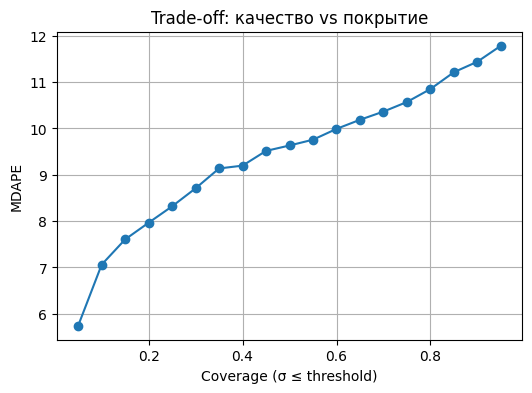

In [ ]:
quantiles   = np.linspace(0.05, 0.95, 19)    # будем выбирать пороги по квантилям
coverage    = []
mdape_list  = []

for q in quantiles:
    thr = np.quantile(sigma, q) # порог
    mask = sigma <= thr # уверенные точки
    cov  = mask.mean() # доля выборки
    err  = mdape(y_test[mask], y_hat[mask]) # MDAPE
    coverage.append(cov)
    mdape_list.append(err)

plt.figure(figsize=(6,4))
plt.plot(coverage, mdape_list, marker='o')
plt.xlabel("Coverage (σ ≤ threshold)")
plt.ylabel("MDAPE")
plt.title("Trade-off: качество vs покрытие")
plt.grid(True)
plt.show()


**Вывод:**

График на реальных данных показывает, что точность модели (MDAPE) значительно улучшается на подмножестве данных, где модель демонстрирует низкую дисперсию. Это подтверждает, что uncertainty-маска может использоваться как фильтр для отбора примеров, где модель работает особенно надёжно.

Такой подход полезен в практических сценариях, где модель не обязана делать предсказания на 100% данных, а может ограничиться уверенной зоной применения.

Для самостоятельного изучения

[MAPIE](https://mapie.readthedocs.io/en/latest/)